# AI in Image and Video Processing
## Assignment 1
TeamWork by:
- Sameera Holy SHEIK ABDULLAH
- Mugil Raja RAMAMOORTHY KOLANCHI

# Import Libraries



In [17]:
import tensorflow as tf
import keras
from keras.preprocessing import image
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
import os, numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam, SGD
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator

In [2]:
print(tf.__version__)

2.12.0


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Problem: Find My Pet

The Dataset consists of 2 classes which are **cat** and **rabbit**. The goal of this model is to identify my pet as "cat" by correctly classifing cats from rabbits.

# Load Dataset

In [4]:
trainpath = r"drive/MyDrive/EPITA/CV/Assignment 1/Data/train-cat-rabbit"
valpath = r"drive/MyDrive/EPITA/CV/Assignment 1/Data/val-cat-rabbit"
testpath = r"drive/MyDrive/EPITA/CV/Assignment 1/Data/test-images"

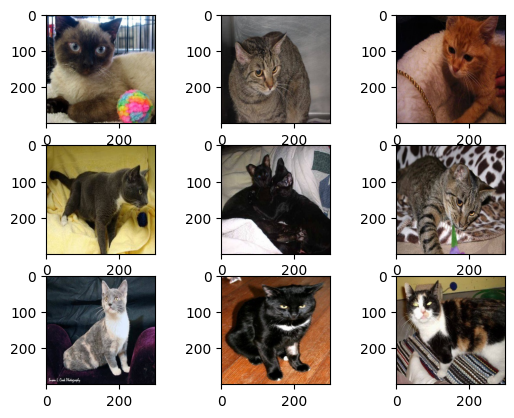

In [5]:
catpath = os.path.join(trainpath, "cat/")

for i in range(9):
  plt.subplot(330 + 1 + i)
  filename = catpath + 'cat.' + str(i+1) + '.jpg'
  image = imread(filename)
  plt.imshow(image)

plt.show()


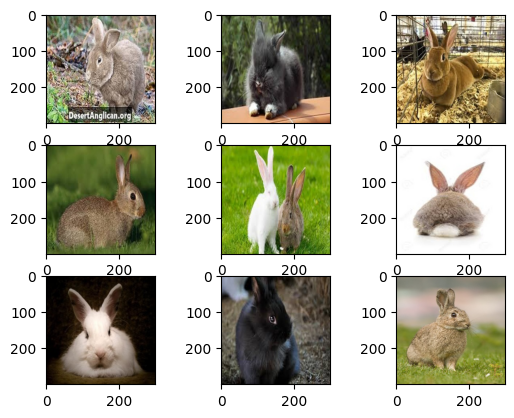

In [6]:
rabbitpath = os.path.join(trainpath, "rabbit/")

for i in range(9):
  plt.subplot(330 + 1 + i)
  filename = rabbitpath + 'rabbit.' + str(i+1) + '.jpg'
  image = imread(filename)
  plt.imshow(image)

plt.show()


## Load Images for training and testing

In [7]:
trdata = ImageDataGenerator(preprocessing_function=preprocess_input)
training_set = trdata.flow_from_directory(directory=trainpath,batch_size=20,class_mode='binary', target_size=(224,224))
tsdata = ImageDataGenerator(preprocessing_function=preprocess_input)
test_set = tsdata.flow_from_directory(directory=testpath,batch_size=10,class_mode='binary', target_size=(224,224))

Found 1600 images belonging to 2 classes.
Found 15 images belonging to 2 classes.


## Data Augmentation

ImageDataGenerator is used to perfrom data augmentarion and rescaling of the input images which helps the model to train better and not overfit. It is applied on the train and test images

In [8]:
CLASS_NAMES = ["cat", "rabbit"]

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

print("Training Set:")
training_set = train_datagen.flow_from_directory(trainpath,
                                                  target_size = (224,224),
                                                  batch_size = 32,
                                                  classes = CLASS_NAMES,
                                                  class_mode = "binary")

print("\nValidation Set:")
val_set = val_datagen.flow_from_directory(valpath,
                                            target_size = (224,224),
                                            batch_size = 32,
                                            classes = CLASS_NAMES,
                                            class_mode = 'binary')

print("\nTest Set:")
test_set = test_datagen.flow_from_directory(testpath,
                                            target_size = (224,224),
                                            batch_size = 32,
                                            classes = CLASS_NAMES,
                                            class_mode = 'binary')

Training Set:
Found 1600 images belonging to 2 classes.

Validation Set:
Found 414 images belonging to 2 classes.

Test Set:
Found 15 images belonging to 2 classes.


## VGG16 Pretrained Model

- Using the weights from imagenet to get the pretrained model.
- The final layer is set to 1 neuron because we have binary class.
- include_top is set to False as we are adding a flatten and dense after the pretrained vgg model

In [10]:
vgg = VGG16(
    input_shape=[224,224, 3],
    include_top=False,
    weights='imagenet')

#x = Flatten()(vgg.output)
x = GlobalAveragePooling2D()(vgg.output)
x = Dense(256, activation = "relu")(x)
final_layer = Dense(1, activation='sigmoid')(x)

## Create the model

- As the classes are binary, we are using "binary cross entropy".
- After different trials, the learning rate is set to 0.0001 for the model to converge slowly and potentially not miss the optimal solution

In [11]:
model = Model(vgg.input, final_layer)
model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001), metrics = 'accuracy')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Early Stopping

It is used to stop the model early
- to monitor the training "loss"
- "min" is used as mode as the monitored metric "loss" should decrease to be considered an improvement
- patience is set to 7, it is like a stopping parameter. When there is no improvement for continuous 7 epochs, the training will be stopped.

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=7, restore_best_weights=True)

## Train the model

In [13]:
epoch = 50

In [14]:
history = model.fit(training_set,
                    steps_per_epoch = training_set.samples//training_set.batch_size,
                    validation_data = val_set,
                    epochs = epoch,
                    callbacks=[early_stopping])

Epoch 1/50
50/50 [==============================] - 56s 747ms/step - loss: 0.6347 - accuracy: 0.6825 - val_loss: 0.5590 - val_accuracy: 0.7754
Epoch 2/50
50/50 [==============================] - 33s 661ms/step - loss: 0.4960 - accuracy: 0.8087 - val_loss: 0.4336 - val_accuracy: 0.8140
Epoch 3/50
50/50 [==============================] - 32s 645ms/step - loss: 0.4117 - accuracy: 0.8250 - val_loss: 0.3970 - val_accuracy: 0.8188
Epoch 4/50
50/50 [==============================] - 32s 643ms/step - loss: 0.3693 - accuracy: 0.8469 - val_loss: 0.3276 - val_accuracy: 0.8744
Epoch 5/50
50/50 [==============================] - 32s 642ms/step - loss: 0.3460 - accuracy: 0.8481 - val_loss: 0.2931 - val_accuracy: 0.8913
Epoch 6/50
50/50 [==============================] - 33s 653ms/step - loss: 0.3124 - accuracy: 0.8650 - val_loss: 0.2470 - val_accuracy: 0.9130
Epoch 7/50
50/50 [==============================] - 32s 636ms/step - loss: 0.2656 - accuracy: 0.8881 - val_loss: 0.2163 - val_accuracy: 0.9130

## Plot the training vs validation loss

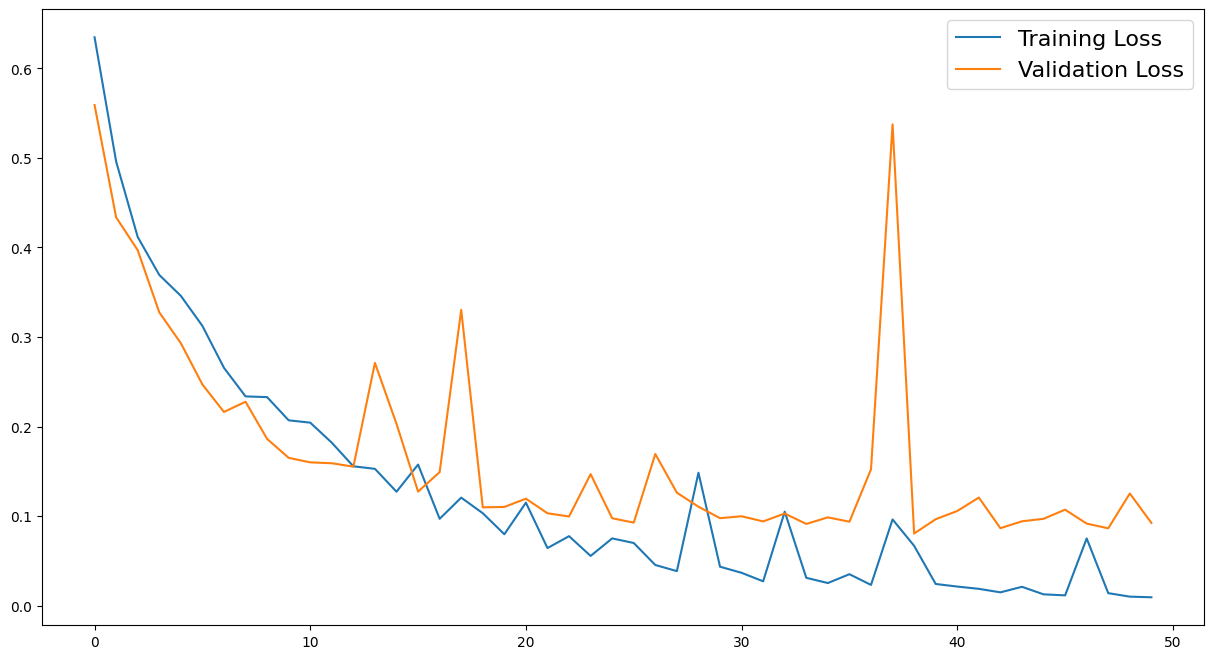

In [15]:
loss = history.history
plt.figure(figsize=(15,8))
plt.plot(np.arange(0,epoch), loss["loss"], label="Training Loss")
plt.plot(np.arange(0,epoch), loss["val_loss"], label="Validation Loss")

plt.legend(fontsize=16)
plt.show()

In [16]:
model.save('drive/MyDrive/EPITA/CV/Assignment 1/FindMyPet_Model.h5')

## Confusion Matrix

In [42]:
import numpy as np
import os
from PIL import Image
from sklearn.metrics import confusion_matrix

classA_path = 'drive/MyDrive/EPITA/CV/Assignment 1/Data/test-images/cat'
classB_path = 'drive/MyDrive/EPITA/CV/Assignment 1/Data/test-images/rabbit'

# Load the model
model = keras.models.load_model('drive/MyDrive/EPITA/CV/Assignment 1/FindMyPet_Model.h5')

# Initialize the true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over images in Class 1 - CAT
classA_files = os.listdir(classA_path)
for filename in classA_files:
    image_path = os.path.join(classA_path, filename)
    image = Image.open(image_path)
    image = image.resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    true_labels.append(0)
    predicted_labels.append(model.predict(image)[0])

# Iterate over images in Class 2 - RABBIT
classB_files = os.listdir(classB_path)
for filename in classB_files:
    image_path = os.path.join(classB_path, filename)
    image = Image.open(image_path)
    image = image.resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    true_labels.append(1)
    predicted_labels.append(model.predict(image)[0])

# Convert the true and predicted labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels.round())

print("Confusion Matrix:")
print(cm)


1/1 [==============================] - 0s 101ms/step
Confusion Matrix:
[[10  0]
 [ 0  5]]


From the test-images, we can see there is no FP or FN. We have 100% accuracy

In [70]:
import joblib
joblib.dump(model, "drive/MyDrive/EPITA/CV/Assignment 1/model.pkl")

['drive/MyDrive/EPITA/CV/Assignment 1/model.pkl']

# Load Model and Predict

In [83]:
def is_my_pet(img_path, model):

  path = img_path
  test_image = Image.open(path)
  test_image = test_image.resize((224, 224))
  test_image = np.array(test_image) / 255.0
  test_image = np.expand_dims(test_image, axis=0)

  predictions = model.predict(test_image)

  predicted_class = "Yes, It is your pet, CAT" if predictions[0] < 0.5 else "No, It is not your pet, it is a rabbit"

  print("Predicted class:", predicted_class)

In [84]:
from PIL import Image

In [85]:
model = keras.models.load_model('drive/MyDrive/EPITA/CV/Assignment 1/FindMyPet_Model.h5')

1/1 [==============================] - 0s 150ms/step
Predicted class: Yes, It is your pet, CAT


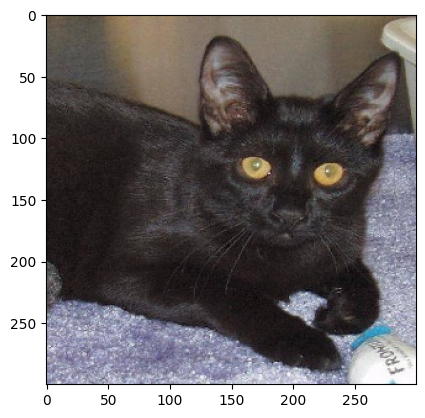

In [86]:
test_image_1 = r'drive/MyDrive/EPITA/CV/Assignment 1/Data/test-images/cat/cat.208.jpg'
image = imread(test_image_1)
plt.imshow(image)
is_my_pet(test_image_1, model)

1/1 [==============================] - 0s 24ms/step
Predicted class: No, It is not your pet, it is a rabbit


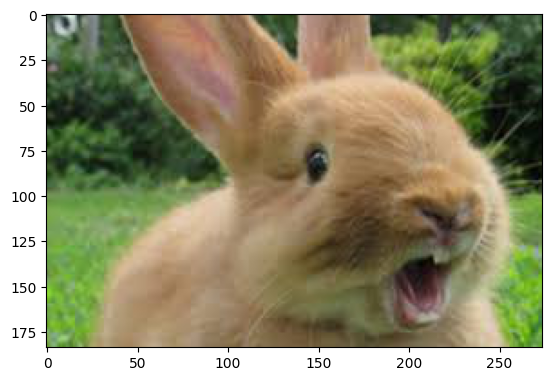

In [87]:
test_image_2 = r'drive/MyDrive/EPITA/CV/Assignment 1/Data/test-images/rabbit/images-2.jpeg'
image = imread(test_image_2)
plt.imshow(image)
is_my_pet(test_image_2, model)